In [37]:
# Import dependencies

import io
import netCDF4
import pandas as pd

import pygmt
import random
import geopy.distance
import numpy as np
from scipy import stats
from scipy import spatial
from global_land_mask import globe

import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.ticker import MultipleLocator
from matplotlib.patches import Rectangle
import cartopy.crs as ccrs
import cartopy.feature as cf

In [3]:
# Import deposit data

mags = pd.read_csv("mag_Ni_karol_181117.csv") # Magmatic Ni

cgid = pd.read_csv("IOCG_skirrow_2022.csv") # All Cu-Ag-Fe deposits
iocg = cgid[cgid['Type'].isin(["Arc_CuAuFe", "Orogenic_CuAuFe"])] # Filter for arc-hosted and orogenic type IOCG
iocg = iocg.reset_index(drop = True)
arch = cgid[cgid['Type'].isin(["Arc_CuAuFe"])] # Only arc-hosted type
arch = arch.reset_index(drop = True)
syno = cgid[cgid['Setting'].isin(["syn"])] # Only syn-orogenic type
syno = syno.reset_index(drop = True)
poso = cgid[cgid['Setting'].isin(["late"])] # Only post-orogenic type
poso = poso.reset_index(drop = True)

fevs = pd.read_csv("fev_edgar_2022.csv") # Five-element veins
vmsd = pd.read_csv("VMS_Database.csv") # VMS 


# Sort deposit data into multi-dimensional arrays

## Create empty arrays for each deposit type with number of columns equal to number of data types available:
## Magmatic Ni (4): Longitude, Latitude, Age, Metal content
## All IOCG types (2): Longitude, Latitude
## Five-element veins (3): Longitude, Latitude, Age
## VMS (3): Longitude, Latitude, Age
data_mags = np.empty((len(mags), 4))
data_iocg = np.empty((len(iocg), 2))
data_arch = np.empty((len(arch), 2))
data_syno = np.empty((len(syno), 2))
data_poso = np.empty((len(poso), 2))
data_fevs = np.empty((len(fevs), 3))
data_vmsd = np.empty((len(vmsd), 3))


data_mags[..., 0] = mags['Longitude']
data_mags[..., 1] = mags['Latitude']
data_mags[..., 2] = mags['Age_Ga']
data_mags[..., 3] = mags['Global_Ni_metal_Mt']

data_iocg[..., 0] = iocg['Longitude']
data_iocg[..., 1] = iocg['Latitude']

data_arch[..., 0] = arch['Longitude']
data_arch[..., 1] = arch['Latitude']

data_syno[..., 0] = syno['Longitude']
data_syno[..., 1] = syno['Latitude']

data_poso[..., 0] = poso['Longitude']
data_poso[..., 1] = poso['Latitude']


age_fevs = np.array(fevs['Age (Ma)'])
for i in range(len(age_fevs)): # Assign NaN where age is unavailable
    if type(age_fevs[i]) == float:
        i += 1
    elif '<' in age_fevs[i] or age_fevs[i] == 'ND':
        age_fevs[i] = np.nan
    elif type(age_fevs[i]) == str:
        age_fevs[i] = float(age_fevs[i]) 

data_fevs[..., 0] = fevs['Longitude']
data_fevs[..., 1] = fevs['Latitude']
data_fevs[..., 2] = age_fevs / 1000 # Convert Ma to Ga


age_vmsd = np.array(vmsd['Age_(Ga)'])
for i in range(len(age_vmsd)): # Assign NaN where age is unavailable
    if age_vmsd[i] == 'ND':
        age_vmsd[i] = np.nan
    elif type(age_vmsd[i]) == str:
        age_vmsd[i] = float(age_vmsd[i])


data_vmsd[..., 0] = vmsd['Longitude']
data_vmsd[..., 1] = vmsd['Latitude']
data_vmsd[..., 2] = age_vmsd

# Code Workflow

In [4]:
import time
start_time = time.monotonic()

In [5]:
# Import LAB Maps

sl13 = netCDF4.Dataset("SL2013sv.nc", 'r') # SL2013_sv
lith = netCDF4.Dataset("LAB_litho1.0.grd", 'r') # LITHO1.0
a006 = netCDF4.Dataset("A2006_lithosphere.grd", 'r') # A2006
lr18 = netCDF4.Dataset("afonso_2019_LAB_0.25d.grd", 'r') # LithoRef18
cm16 = netCDF4.Dataset("CAM2016_LAB_0.5d.grd", 'r') # CAM2016


# SLNAAFSA
## Remove data point error (939 km depth)
xyz_snas = pygmt.grd2xyz(grid = "SLNAAFSA.nc", output_type = "pandas")
xyz_snas = xyz_snas.loc[xyz_snas['z'] < max(xyz_snas['z'])]
grd_snas = pygmt.xyz2grd(x = xyz_snas['x'], y = xyz_snas['y'], z = xyz_snas['z'], 
              region = "d", spacing = 0.5, outgrid = "SLNAAFSA_fix.nc")
snas = netCDF4.Dataset("SLNAAFSA_fix.nc", 'r') 


# Append FR12 to SLNAAFSA
xyz_fr12 = pygmt.grd2xyz(grid = "FR12.nc", output_type = "pandas")
fr12 = netCDF4.Dataset("FR12.nc", 'r') 
snas_aus = xyz_snas.loc[(xyz_snas['x'] >= min(xyz_fr12['x'])) & (xyz_snas['x'] <= max(xyz_fr12['x'])) 
                        & (xyz_snas['y'] >= min(xyz_fr12['y'])) & (xyz_snas['y'] <= max(xyz_fr12['y']))]
concat_snfr = pd.concat([xyz_fr12, xyz_snas.drop(labels = snas_aus.index, axis = 0)])

In [6]:
# Functions

def random_points(n, size):
    '''
    Randomly draw onshore coordinate pairs from a uniform distribution.
    
        Parameters:
            n (int): Number of onshore coordinate sets
            size (int): Number of onshore coordinate pairs in each set
            
        Returns:
            A tuple of three arrays containing longitude-latitude pairs with index:
                [0]: All onshore and offshore locations
                [1]: Only onshore locations
                [2]: Only offshore locations
    '''   
    arrrandom = np.empty((0, 2))
    arronshore = np.empty((0, 2))
    arroffshore = np.empty((0, 2))
    
    while len(arronshore) < size * n:
        
        # Randomly select from a uniform distribution two variables between 0 and 1.
        a = random.uniform(0, 1)
        b = random.uniform(0, 1)
        
        # Convert numbers into lon and lat using area-normalised relationships
        lons = 360 * a - 180
        lats = 180 / np.pi * np.arcsin(2 * b - 1)
        
        arrrandom = np.append(arrrandom, np.array([[lons, lats]]), axis = 0)
        
        # Filter for onshore locations
        if globe.is_land(lats, lons) == True: 
            arronshore = np.append(arronshore, np.array([[lons, lats]]), axis = 0)
        else:
            arroffshore = np.append(arroffshore, np.array([[lons, lats]]), axis = 0)
    return arrrandom, arronshore, arroffshore


def get_cdf(data, binwidth, cdf_only = False):
    '''
    Calculate CDF and PDF for a dataset.
    
        Parameters:
            data (one-dimensional array): Nearest distances from location to LAB
            binwidth (int): CDF bin width
            
        Returns:
            A tuple of three arrays with index:
             [0]: CDF
             [1]: PDF
             [2]: Bin lower interval
    '''
    count, bin_lower = np.histogram(data, bins = np.arange(0, max(data), binwidth))
    pdf = count / sum(count)
    cdf = np.cumsum(pdf)
    
    if cdf_only == True:
        return cdf
    
    else:
        return cdf, pdf, bin_lower


def get_std(data, binwidth):
    '''
    Sort data into bins and calculate standard deviation for each bin.
    
        Parameters:
            data (one-dimensional array): Nearest distances from location to LAB
            binwidth (int): CDF bin width
        
        Returns:
            An array of standard deviations calculated for every bin
    '''
    # Sort and assign values into bins
    sort_dist = np.sort(data)
    bins = np.arange(0, max(sort_dist), binwidth)
    digit = np.digitize(sort_dist, bins)
    
    std_random = np.empty((0))
    
    # Calculate std for values in each bin
    for i in range(1, len(bins) + 1):
        std_random = np.append(std_random, np.std(sort_dist[np.where(digit == i)[0]])) 
    
    return std_random


def get_cdfsets(data, set_size, n_bins, binwidth, cdf_only = False, std_only = False):
    '''
    Organise one-dimensional data into sets, calculate CDF and std for each set, 
    and calculate average CDF and std for each same bin interval for all sets.
        
        Parameters:
            data (one-dimensional array): Nearest distances from location to LAB
            set_size (int): Number of values in each set
            n_bins (int): Number of bins
            binwidth (int): CDF bin width
        
        Returns:
            A tuple of two lists with index:
                [0]: average CDF
                [1]: average standard deviation
    '''
    n_col = int(len(data) / set_size)
    arr = np.empty((set_size, n_col))
    start = 0
    i = 0
    
    # Organise data into a set_size x n_col matrix
    while start < n_col:
        arr[..., i] = data['distance'][start::n_col]
        start += 1
        i += 1
    
    # Calculate CDF for each matrix row
    cdf = list()
    for j in range(len(arr)):
        cdf.append(get_cdf(arr[j], binwidth)[0])
        
    # Slice row to size n_bins    
    for i in range(len(cdf)):
        cdf[i] = cdf[i][:n_bins]
        
    # If length of matrix row is less than n_bins, fill with NaN
    for i in range(len(cdf)):
        while len(cdf[i]) < n_bins:
            cdf[i] = np.append(cdf[i], np.nan)
            
    cdf = np.array(cdf)
    
    avr = list()
    std = list()
    
    # Calculate average and std of CDFs for each bin
    for i in range(n_bins):
        avr.append(np.nanmean(cdf[..., i]))
        std.append(np.nanstd(cdf[..., i]))
        
    if cdf_only == True:
        return avr
    
    elif std_only == True:
        return std

    else:
        return avr, std


def get_contour(lab, filename):
    '''
    Extract contour from LAB map and store as ASCII.
        
        Parameters:
            lab (str): LAB map
            filename (str): ASCII file name
            
        Returns:
            Pandas dataframe of contour longitude and latitude
    '''
    if lab == "SLNAAFSA":
        grd = "SLNAAFSA_fix.nc"
    elif lab == "SLNAAFSA_FR12":
        grd = concat_snfr
    elif lab == "SL2013sv":
        grd = "SL2013sv.nc"
    elif lab == "LITHO1.0":
        grd = "LAB_litho1.0.grd"
    elif lab == "A2006":
        grd = "A2006_lithosphere.grd"
    elif lab == "LithoRef18":
        grd = "afonso_2019_LAB_0.25d.grd"
    elif lab == "CAM2016":
        grd = "CAM2016_LAB_0.5d.grd"
        
    fig = pygmt.Figure()  
    
    if lab == "SLNAAFSA_FR12":
        fig.contour(data = grd, levels = str(z) + ',', D = filename)
    else:
        fig.grdcontour(grid = grd, interval = str(z) + ',', D = filename)
    
    return pd.read_csv("contour.ll", delimiter = "\t")


def loc2ll(deposit, random_loc, deposit_filename, random_filename):
    '''
    Write deposit and associated random location set locations as ASCII.
    
        Parameters:
            deposit (DataFrame): Deposit type
            random_loc (DataFrame): Deposit random locations
            deposit_filename (str): Deposit ASCII filename
            random_filename (str): Random location ASCII filename
    '''
    deposit.to_csv(deposit_filename, sep = '\t', index = False)
    deposit[['Longitude', 'Latitude']].to_csv(deposit_filename, sep = '\t', index = False)
    pd.DataFrame(random_loc[1]).to_csv(random_filename, index = False, header = ['lon', 'lat'])
    
    
def closest_approach(data, contour):
    '''
    Calculate the nearest approach from a data location to the LAB depth contour.
        
        Parameters:
            data (str): Data location ASCII file
            contour (str): LAB depth contour ASCII file
            
        Returns:
            Pandas DataFrame containing:
            [0] data longitude, [1] data latitude, [2] nearest distance, [3] contour longitude, [4] contour latitude
    '''
    # Open shell and perform PyGMT 'mapproject' to calculate closest approach
    with pygmt.clib.Session() as session:
        with pygmt.helpers.GMTTempFile() as tmpfile: # Save output into a temporary file
            session.call_module("mapproject", f"{data} -L{contour}+uk ->{tmpfile.name}")
            closest_distance = tmpfile.read().strip() # Read temporary file
    
    # Convert temporary file into CSV
    distance = pd.read_csv(io.StringIO(closest_distance), sep=" ", header = None)
    distance = pd.DataFrame({"lon_data":distance[0], "lat_data":distance[1],
                             "distance":distance[2], "lon_contour":distance[3], "lat_contour":distance[4]})
    
    return distance
    

def ks2(data1, data2, n):
    '''
    2-sample Kolmogorov-Smirnov test comparing data1 to multiple data2 CDFs. 
        
        Parameters:
            data1 (one-dimensional arr): Data CDF
            data2 (one-dimensional arr): n number of CDFs of random locations
            
        Returns:
            An array of D value and p-value pairs. 
    '''
    d = np.empty((0))
    p = np.empty((0))
    lower = 0
    upper = int(len(data2) / n)
    
    for i in range(n):
        d_ks = stats.ks_2samp(data1, data2[lower:upper])[0] # D value between data1 and all data2 CDFs 
        p_ks = stats.ks_2samp(data1, data2[lower:upper])[1] # p-value between data1 and all data2 CDFs 
        d = np.append(d, d_ks)
        p = np.append(p, p_ks)
        lower += int(len(data2) / n)
        upper += int(len(data2) / n)
        
    return np.array([[d], [p]])

In [7]:
# Generate sets of 100 random onshore locations

random.seed(999)

## Define number of random CDFs
n_randomcdf = 100

## Random test sets
rset1 = random_points(100, 1) # One random set of 100 onshore locations
rset2 = random_points(100, 1)
rset3 = random_points(100, 1)
rset4 = random_points(10000, 1) # One random set of 10,000 onshore locations

## n_randomcdf number of random sets of length equal to number of deposits 
rmags = random_points(len(data_mags), n_randomcdf)
riocg = random_points(len(data_iocg), n_randomcdf)
rarch = random_points(len(data_arch), n_randomcdf)
rsyno = random_points(len(data_syno), n_randomcdf)
rposo = random_points(len(data_poso), n_randomcdf)
rfevs = random_points(len(data_fevs), n_randomcdf)

In [8]:
# Calculate CDFs for random locations

## Define LAB contour and chosen LAB map
z = 210
lab = 'SLNAAFSA_fix.nc'

## Locate z contour on chosen LAB
fig = pygmt.Figure()
fig.grdcontour(grid=lab, interval = str(z) + ',', D = "contour.ll")
contour = pd.read_csv("contour.ll", delimiter = '\t')

pd.DataFrame(rset4[1]).to_csv('rset4.ll', index = False, header = ['lon', 'lat'])

## Calculate closest approach from each random location to the LAB contour
with pygmt.clib.Session() as session:
    with pygmt.helpers.GMTTempFile() as tmpfile:
        session.call_module("mapproject", f"rset4.ll -Lcontour.ll+uk ->{tmpfile.name}")
        closest_distance = tmpfile.read().strip()

rset4dist = pd.read_csv(io.StringIO(closest_distance), sep=" ", header = None)
rset4dist = pd.DataFrame({"lon deposit":rset4dist[0], "lat deposit":rset4dist[1],
                          "distance":rset4dist[2], "lon contour":rset4dist[3], "lat contour":rset4dist[4]})

## Define number of histogram bins
bins = 10

##
cdf_rset4dist = get_cdf(rset4dist['distance'], bins)
std_rset4dist = get_std(rset4dist['distance'], bins)
cdf_rset4distsplit = get_cdfsets(rset4dist, set_size = n_randomcdf, n_bins = 141, binwidth = bins)

C:\Users\edgar\anaconda3\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\edgar\anaconda3\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\edgar\anaconda3\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [9]:
# Define LAB depth contour in km

z = 210 

In [10]:
# Extract contour from LAB maps and write as ASCII

contour_snas = get_contour("SLNAAFSA", "contour_snas.ll")
contour_snfr = get_contour("SLNAAFSA_FR12", "contour_snfr.ll")
contour_sl13 = get_contour("SL2013sv", "contour_sl13.ll")
contour_lith = get_contour("LITHO1.0", "contour_lith.ll")
contour_a006 = get_contour("A2006", "contour_a006.ll")
contour_lr18 = get_contour("LithoRef18", "contour_lr18.ll")
contour_cm16 = get_contour("CAM2016", "contour_cm16.ll")

In [11]:
# Write deposit and random locations as ASCII
    
loc2ll(mags, rmags, "mags.ll", "rmags.ll")

loc2ll(fevs, rfevs, "fevs.ll", "rfevs.ll")

loc2ll(iocg, riocg, "iocg.ll", "riocg.ll")
loc2ll(arch, rarch, "arch.ll", "rarch.ll")
loc2ll(syno, rsyno, "syno.ll", "rsyno.ll")
loc2ll(poso, rposo, "poso.ll", "rposo.ll")

vmsd.to_csv('vmsd.ll', sep = '\t', index = False)
vmsd[['Longitude', 'Latitude']].to_csv('vmsd.ll', sep = '\t', index = False)

In [12]:
# Calculate closest approach from each deposit/random location to the LAB depth contour

all_dep = ["mags.ll", "fevs.ll", "iocg.ll", "arch.ll", "syno.ll", "poso.ll"]
all_random = ["rmags.ll", "rfevs.ll", "riocg.ll", "rarch.ll", "rsyno.ll", "rposo.ll"]
all_lab = ["contour_snas.ll", "contour_snfr.ll", "contour_sl13.ll", "contour_lith.ll",
           "contour_a006.ll", "contour_lr18.ll", "contour_cm16.ll"]


dep2contour = []

for e in all_dep:
    for f in all_lab:
        dep2contour.append(closest_approach(e, f))
        
dep2contour = np.array(dep2contour, dtype = object)
shape = (6, 7)
dep2contour = dep2contour.reshape(shape)


random2contour = []

for g in all_random:
    for h in all_lab:
        random2contour.append(closest_approach(g, h))
        
random2contour = np.array(random2contour, dtype = object)
shape = (6, 7)
random2contour = random2contour.reshape(shape)

In [13]:
# Identify the nearest VMS deposit to each five-element vein/random location

vmsd_ll = pd.read_csv("vmsd.ll", delimiter = '\t')
tree = spatial.KDTree(vmsd_ll)

dist = np.empty(0)
lon_vmsd = np.empty(0)
lat_vmsd = np.empty(0)
for i in range(len(fevs)):
    a = data_fevs[..., 0][i]
    b = data_fevs[..., 1][i]
    coords_fevs = (b, a)
    d = tree.query((data_fevs[..., 0][i], data_fevs[..., 1][i]))
    coords_vmsd = (data_vmsd[..., 1][d[1]], data_vmsd[..., 0][d[1]])
    dist = np.append(dist, geopy.distance.geodesic(coords_fevs, coords_vmsd).km) # Geodesic distance
    lon_vmsd = np.append(lon_vmsd, data_vmsd[..., 0][d[1]])
    lat_vmsd = np.append(lat_vmsd, data_vmsd[..., 1][d[1]])
    
dict_fevsvmsd = {
    "lon fevs": data_fevs[..., 0],
    "lat fevs": data_fevs[..., 1],
    "distance": dist,
    "lon vmsd": lon_vmsd,
    "lat vmsd": lat_vmsd
}

fevs_vmsd = pd.DataFrame(dict_fevsvmsd)


dist = np.empty(0)
lon_vmsd = np.empty(0)
lat_vmsd = np.empty(0)
for i in range(len(rfevs[1])):
    a = rfevs[1][i][0]
    b = rfevs[1][i][1]
    coords_rfevs = (b, a)
    d = tree.query([(rfevs[1][i][0], rfevs[1][i][1])])
    coords_vmsd = (data_vmsd[..., 1][d[1]], data_vmsd[..., 0][d[1]])
    dist = np.append(dist, geopy.distance.geodesic(coords_rfevs, coords_vmsd).km) # Geodesic distance
    lon_vmsd = np.append(lon_vmsd, data_vmsd[..., 0][d[1]])
    lat_vmsd = np.append(lat_vmsd, data_vmsd[..., 1][d[1]])   
    
dict_rfevsvmsd = {
    "lon fevs": rfevs[1][..., 0],
    "lat fevs": rfevs[1][..., 1],
    "distance": dist,
    "lon vmsd": lon_vmsd,
    "lat vmsd": lat_vmsd
}

rfevs_vmsd = pd.DataFrame(dict_rfevsvmsd)

In [14]:
# Generate CDFs for data/random location distances and standard deviations for random locations
## Deposit/random index: [0] mags, [1] fevs, [2], iocg, [3] arch, [4] syno, [5] poso
## LAB map index: [0] SLNAAFSA, [1] SLNAAFSA + FR12, [2] SL2013sv, [3] LITHO1.0, [4] A2006, [5] LithoRef18, [6] CAM2016

bins = 10

i = 0
j = 0
all_depcdf = []
for i in range(len(dep2contour)):
    for j in range(len(dep2contour[i])):
        all_depcdf.append(get_cdf(dep2contour[i][j]["distance"], bins, cdf_only = True))

all_depcdf = np.array(all_depcdf, dtype = object)
shape = (6, 7)
all_depcdf = all_depcdf.reshape(shape)
        

i = 0
j = 0
all_randomcdf = []
all_randomcdfsplit = []
all_randomstdsplit = []
for i in range(len(random2contour)):
    for j in range(len(random2contour[i])):
        all_randomcdf.append(get_cdf(random2contour[i][j]["distance"], bins, cdf_only = True))
        all_randomcdfsplit.append(get_cdfsets(random2contour[i][j], set_size = n_randomcdf, n_bins = 150, binwidth = bins,
                                              cdf_only = True))
        all_randomstdsplit.append(get_cdfsets(random2contour[i][j], set_size = n_randomcdf, n_bins = 150, binwidth = bins,
                                              std_only = True))

all_randomcdf = np.array(all_randomcdf, dtype = object)
shape = (6, 7)
all_randomcdf = all_randomcdf.reshape(shape)

all_randomcdfsplit = np.array(all_randomcdfsplit, dtype = object)
all_randomstdsplit = np.array(all_randomstdsplit, dtype = object)

all_randomcdfsplit = all_randomcdfsplit.reshape((all_randomcdfsplit.shape[0], 1, all_randomcdfsplit.shape[1]))
shape = (6, 7, 150)
all_randomcdfsplit = all_randomcdfsplit.reshape(shape)

all_randomstdsplit = all_randomstdsplit.reshape((all_randomstdsplit.shape[0], 1, all_randomstdsplit.shape[1]))
all_randomstdsplit = all_randomstdsplit.reshape(shape)


# Additional CDFs

## Magmatic sulphide CDF weighted by metal content

i = 0
cdf_magswt = []
for i in range(len(all_lab)):
    count, bins_count = np.histogram(dep2contour[0][i]['distance'],
                                     bins = np.arange(0, max(dep2contour[0][i]['distance']), 10),
                                     weights = data_mags[..., 3] / sum(data_mags[..., 3]))
    pdf = count / sum(count)
    cdf = np.cumsum(pdf)
    cdf_magswt.append(cdf)
    
cdf_magswt = np.array(cdf_magswt, dtype = object)

cdf_fevsvmsd = get_cdf(fevs_vmsd['distance'], 1)
cdf_rfevsvmsd = get_cdf(rfevs_vmsd['distance'], 1)
std_rfevsvmsd = get_std(rfevs_vmsd['distance'], 1)

C:\Users\edgar\anaconda3\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\edgar\anaconda3\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\edgar\anaconda3\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [16]:
# Kolmogrow-Smirnov test: Calculate D value and p-value
## Deposit/random index: [0] mags, [1] fevs, [2], iocg, [3] arch, [4] syno, [5] poso
## LAB map index: [0] SLNAAFSA, [1] SLNAAFSA + FR12, [2] SL2013sv, [3] LITHO1.0, [4] A2006, [5] LithoRef18, [6] CAM2016

## Same LAB K-S test for all deposits
i = 0
j = 0
all_d = []
all_p = []
for i in range(len(dep2contour)):
    for j in range(len(dep2contour[i])):
        all_d.append(ks2(dep2contour[i][j]['distance'], random2contour[i][j]['distance'], 100)[0])
        all_p.append(ks2(dep2contour[i][j]['distance'], random2contour[i][j]['distance'], 100)[1])

shape = (6, 7, 100)
all_d = np.array(all_d, dtype = object)
all_d = all_d.reshape(shape)
all_p = np.array(all_p, dtype = object)
all_p = all_p.reshape(shape)


## VMS vs Five-element vein K-S test
dfevsvmsd = ks2(fevs_vmsd['distance'], rfevs_vmsd['distance'], 100)[0]
pfevsvmsd = ks2(fevs_vmsd['distance'], rfevs_vmsd['distance'], 100)[1]


## Regional vs Global SLNAAFSA LAB K-S test
i = 0 
d_regglo = []
p_regglo = []
for i in range(len(dep2contour)):
    d_regglo.append(ks2(dep2contour[i][1]['distance'], random2contour[i][0]['distance'], 100)[0])
    p_regglo.append(ks2(dep2contour[i][1]['distance'], random2contour[i][0]['distance'], 100)[1])


In [18]:
# Take the log of p-values

for x in range(len(all_p)):
    for y in range(len(all_p[x])):
        for z in range(len(all_p[x][y])):
            all_p[x][y][z] = np.log10(all_p[x][y][z])
            
for x in range(len(pfevsvmsd)):
    for y in range(len(pfevsvmsd[x])):
            pfevsvmsd[x][y] = np.log10(pfevsvmsd[x][y])

for x in range(len(p_regglo)):
    for y in range(len(p_regglo[x])):
        for z in range(len(p_regglo[x][y])):
            p_regglo[x][y][z] = np.log10(p_regglo[x][y][z])


In [19]:
# Define LAB depth range in km

z_min = 120
z_max = 260 

z_range = np.arange(z_min, z_max + 1, 10)

In [20]:
p_sweep = []
labmap = "SLNAAFSA"

i = 0
for i in range(len(z_range)):
    z = z_range[i]
    contour_lab = get_contour(labmap, "contour_sweep.ll")
    
    dep2contour = []
    for e in all_dep:
        dep2contour.append(closest_approach(e, "contour_sweep.ll"))
        
    random2contour = []
    for f in all_random:
        random2contour.append(closest_approach(f, "contour_sweep.ll"))
    
    all_p = []
    for j in range(len(dep2contour)):
        all_p.append(ks2(dep2contour[j]['distance'], random2contour[j]['distance'], 100)[1])
        
    for x in range(len(all_p)):
        for y in range(len(all_p[x])):
            all_p[x][y] = np.log10(all_p[x][y])
        
    p_sweep.append(all_p)
    print("Calculated K-S test for LAB depth =", z_range[i], " km")

120
130
140
150
160
170
180
190
200
210
220
230
240
250
260


In [22]:
from datetime import timedelta
end_time = time.monotonic()
print(timedelta(seconds=end_time - start_time))

0:56:31.578000


# Figures

In [62]:
# Functions

my_purple = "#5F0F40"
my_red = "#9A031E"
my_yellow = "#FB8B24"
my_orange = "#E36414"
my_teal = "#0F4C5C"

def map_random_points(data, ax, marker_size):
    '''
    Map random points with different colours for onshore and offshore points.
        
        Parameters:
            data (tuple of arrays): Random location data
            ax (variable): Figure axis
            marker_size (float): Marker size
            
        Returns:
            Cartopy Robinson projection map with onshore and offshore points plotted in different colours
    '''    
    ax.set_global()
    ax.add_feature(cf.COASTLINE, linewidth = 0.5)
    ax.scatter(x = data[1][..., 0], y = data[1][..., 1],
               s = marker_size, alpha = 0.5, c = my_teal, transform = ccrs.PlateCarree())
    ax.scatter(x = data[2][..., 0], y = data[2][..., 1],
               s = marker_size, alpha = 0.5, c = my_yellow, transform = ccrs.PlateCarree())
    ax.annotate("Total = " + str(len(data[0])),
                xy=(0.995, 0.06), xycoords='axes fraction', ha='right', va='bottom', fontsize = 8)
    ax.annotate("Onshore = " + str(len(data[1])),
            xy=(0.995, 0.01), xycoords='axes fraction', ha='right', va='bottom', fontsize = 8)
    
    
def map_deposit_topo(deposit):
    '''
    Plot deposit locations on global map of topography.
        
        Parameters:
            deposit (str): Selected deposit type from one of: "mags", "fevs" or "iocg"
            
        Returns:
            Map of topography with deposits coloured by age, where available.
    '''
    # Set colourbar age range and assign data array
    fig = pygmt.Figure()
    
    if deposit == "mags":
        series_age = (0, 3.5, 0.1)
        data = data_mags
    elif deposit == "fevs":
        series_age = (0, 2.5, 0.1)
        data = data_fevs
    elif deposit == "iocg":
        data1 = data_arch
        data2 = data_syno
        data3 = data_poso
    
    with fig.subplot(nrows = 1, ncols = 1, figsize = ("18c", "12c"), autolabel = False, margins = "0c"):        
        with fig.set_panel(panel = 0):
            pygmt.makecpt(cmap = "geo")
            fig.grdimage(grid = "ETOPO_2m.grd", projection = "N?", region = "d", frame = "f")
            fig.colorbar(frame = ["a2000f500", "x+lElevation", "y+lm"], 
                         position = "jBC+o0c/-2.5c+w13.5c/0.4c+h") # Major ticks every 2000 m, minor ticks every 500 m
            fig.coast(shorelines = "1/0.3,black") # Draw coastlines
            fig.coast(borders = "1/0.4p,black,.") # Draw country borders
            
            if deposit == "mags" or deposit == "fevs":
                pygmt.makecpt(cmap = "rainbow", series = series_age, reverse = True)
                fig.plot(x = data[..., 0], 
                         y = data[..., 1], 
                         color = data[..., 2],
                         cmap = True,
                         style = "c0.12c",
                         pen = "black")
                fig.colorbar(frame = ("a0.5f0.1", "x+lDeposit Age", "y+lGa"), 
                             position = "jMR+o-2.8c/-0.2c+w9c/0.4c+n") # Major ticks every 0.5 Ga, minor ticks every 0.1 Ga. Colour grey if NaN
            
            elif deposit == "iocg":
                fig.plot(x = data1[..., 0], y = data1[..., 1],
                        color = 'white', style = "c0.12c", pen = "black",
                        label = "Arc-hosted")
                fig.plot(x = data2[..., 0], y = data2[..., 1],
                        color = 'white', style = "s0.12c", pen = "black",
                        label = "Orogenic")
                fig.plot(x = data3[..., 0], y = data3[..., 1],
                        color = 'white', style = "i0.15c", pen = "black",
                        label = "Post-orogenic")
                fig.legend(position = "jBR+o-1c/-1.5c")
            
    fig.show()
    
    
def map_globallab(deposit, lab):
    '''
    Plot deposit locations on a global map of the LAB.

    Parameters:
        deposit (list): list of all selected deposit types in four-letter abbreviation
        lab (str): LAB map
    '''
    fig = pygmt.Figure()
    series_age = (0, 3.5, 0.1)
    series_depth = (0, 300, 20)

    if lab == "SLNAAFSA":
        grd = "SLNAAFSA.nc"
    elif lab == "SL2013sv":
        grd = "SL2013sv.nc"
    elif lab == "LITHO1.0":
        grd = "LAB_litho1.0.grd"
    elif lab == "A2006":
        grd = "A2006_lithosphere.grd"
    elif lab == "LithoRef18":
        grd = "afonso_2019_LAB_0.25d.grd"
    elif lab == "CAM2016":
        grd = "CAM2016_LAB_0.5d.grd"
        
    pygmt.makecpt(cmap = "polar", series = series_depth, reverse = True)
    fig.grdimage(grid = grd, projection = "N18c", region = "d", frame = "f")
    fig.colorbar(frame = ["a50f10", "x+lLithospheric Thickness", "y+lkm"], 
                 position = "jBC+o0c/-2.5c+w13.5c/0.4c+h")
    fig.coast(shorelines = "1/0.3,black")
    fig.coast(borders="1/0.4p,black,.")
    
    pygmt.makecpt(cmap="rainbow", series = series_age, reverse = True)
    markers = ["c0.12c", "s0.12c", "i0.12c", "a0.12c", "d0.12c", "t0.12c", "h0.12c"]
    
    i = 0
    for i in range(len(deposit)):
        if deposit[i] == "mags":
            data = data_mags
            label = "Ni-Cu-PGE"
            c = True
        elif deposit[i] == "iocg":
            data = data_iocg
            label = "IOCG"
            c = False
        elif deposit[i] == "arch":
            data = data_arch
            label = "Arc-hosted"
            c = False
        elif deposit[i] == "syno":
            data = data_syno
            label = "Orogenic"
            c = False
        elif deposit[i] == "poso":
            data = data_poso
            label = "Post-orogenic"
            c = False
        elif deposit[i] == "fevs":
            data = data_fevs
            label = "Five-element veins"
            c = True
        elif deposit[i] == "vmsd":
            data = data_vmsd
            label = "vmsd"
            c = True
            
        fig.plot(x = data[..., 0], 
                 y = data[..., 1], 
                 color = "white",
                 style = markers[i],
                 pen = "black",
                 label = label)
        
        if c == True:
            fig.plot(x = data[..., 0],
                     y = data[..., 1],
                     color = data[..., 2],
                     cmap = True,
                     style = markers[i],
                     pen = "black")
        
        elif c == False:
            fig.plot(x = data[..., 0],
                     y = data[..., 1],
                     style = markers[i],
                     pen = "black",
                     color = "dimgray")
            
    fig.legend(position = "jBR+o-1c/-0.2c")
    fig.colorbar(frame=("a0.5f0.1", "x+lDeposit Age", "y+lGa"), 
                 position = "jMR+o-2.8c/-0.2c+w9c/0.4c+n")
    
    fig.show()
    
    
def map_auslab(deposit):
    '''
    Plot deposit locations on a map of the LAB of Australia.
    
        Parameters:
            deposit (list): list of all selected deposit types in four-letter abbreviation
    '''
    fig = pygmt.Figure()
    series_age = (0, 3, 0.1)
    series_depth = (50, 300, 20)

    pygmt.makecpt(cmap="polar", series=series_depth, reverse = True)
    fig.grdimage(grid="FR12.nc", projection="M18c", frame='f', region = [110, 155, -45, -10])
    fig.colorbar(frame=["a50f25", "x+lLithospheric Thickness", "y+lkm"], position = "jBL+o0c/-1c+w7.5c/0.25c+h")
    fig.coast(shorelines = "1/0.9,black")
    fig.coast(borders="1/0.6p,black,.")
    
    # Draw contours on map
    fig.grdcontour(grid='FR12.nc', interval = z + 10, pen = "0.7p,blue,.")
    fig.grdcontour(grid='FR12.nc', interval = z, pen = "0.7p,blue,4_2:2p")
    fig.grdcontour(grid='FR12.nc', interval = z - 10, pen = "1p,black,4_2:2p")
    fig.grdcontour(grid='FR12.nc', interval = z - 20, pen = "0.7p,red,4_2:2p")
    fig.grdcontour(grid='FR12.nc', interval = z - 30, pen = "0.7p,red,.")

    pygmt.makecpt(cmap="rainbow", series = series_age, reverse = True)
    markers = ["c0.3c", "s0.3c", "i0.3c", "a0.3c", "d0.3c", "t0.3c", "h0.3c"]
    
    i = 0
    for i in range(len(deposit)):
        if deposit[i] == "mags":
            data = data_mags
            label = "Ni-Cu-PGE"
            c = True
        elif deposit[i] == "iocg":
            data = data_iocg
            label = "IOCG"
            c = False
        elif deposit[i] == "arch":
            data = data_arch
            label = "Arc-hosted"
            c = False
        elif deposit[i] == "syno":
            data = data_syno
            label = "Orogenic"
            c = False
        elif deposit[i] == "poso":
            data = data_poso
            label = "Post-orogenic"
            c = False
        elif deposit[i] == "fevs":
            data = data_fevs
            label = "Five-element veins"
            c = True
        elif deposit[i] == "vmsd":
            data = data_vmsd
            label = "vmsd"
            c = True

        fig.plot(x = data[..., 0], 
                 y = data[..., 1], 
                 color = "white",
                 style = markers[i],
                 pen = "black",
                 label = label)
        
        if c == True:
            fig.plot(x = data[..., 0],
                     y = data[..., 1],
                     color = data[..., 2],
                     cmap = True,
                     style = markers[i],
                     pen = "black")
        
        elif c == False:
            fig.plot(x = data[..., 0],
                     y = data[..., 1],
                     style = markers[i],
                     pen = "black",
                     color = "dimgray")            

    fig.legend(position = "jBL", box = "+gwhite+pblack")
    fig.colorbar(frame=["a0.5f0.25", "x+lDeposit Age", "y+lGa"], position = "jBR+o0c/-1c+w7.5c/0.25c+n+h")

    fig.show()
    
    
def plot_cdf(cdf1, randomcdf_split, randomstd_split, cdf2 = False, cdf3 = False):
    '''
    Plot CDFs
    
            Parameters:
                cdf1: CDF on global LAB
                randomcdf_split: CDF of 100 sets of random locations
                randomstd_split: CDF of 100 sets of random locations
                cdf2: CDF on regionally-enhanced LAB
                cdf3: CDF weighted by metal content
    '''
    matplotlib.rcParams['axes.linewidth'] = 2
    fig = plt.figure(figsize = [10, 7])
    ax1 = fig.add_subplot(111)
    
    ax1.axvline(x = 200, color = "black", linestyle = "-.") # Draw line 200 km away from contour
    
    # Set xticks
    x_cdf1 = np.arange(0, len(cdf1) * 10, 10)
    x_random = np.arange(0, 150 * 10, 10)
    
    ax1.plot(x_cdf1, 100 * cdf1, color = my_yellow, 
             label = "Raw number of deposits")
    
    if cdf2 is not False:
        x_cdf2 = np.arange(0, len(cdf2) * 10, 10)  
        ax1.plot(x_cdf2, 100 * cdf2, color = my_teal, 
                 label = "CDF 2")

    if cdf3 is not False:
        x_cdf3 = np.arange(0, len(cdf3) * 10, 10)    
        ax1.plot(x_cdf3, 100 * cdf3, color = my_red,
                 label = "CDF 3")
        
    ax1.plot(x_random, 100 * np.array(randomcdf_split), color = "black", linewidth = 0.6,
             label = "Random continental locations (mean)")
    ax1.plot(x_random, 100 * (np.array(randomcdf_split) + np.array(randomstd_split)), 
             color = "gray", linewidth = 0.5, label = "Random continental locations (standard dev.)")
    ax1.plot(x_random, 100 * (np.array(randomcdf_split) - np.array(randomstd_split)), 
             color = "gray", linewidth = 0.5)
    
    # Colour between random std and mean
    randomcdf_split = np.array(randomcdf_split, dtype = float)
    randomstd_split = np.array(randomstd_split, dtype = float)
    ax1.fill_between(x_random, 
                     100 * (np.array(randomcdf_split) + np.array(randomstd_split)), 
                     100 * (np.array(randomcdf_split) - np.array(randomstd_split)), 
                     color='silver', alpha=0.3)
    
    ax1.set_xlabel("Distance from " + str(z) + " km LAB contour (km)", labelpad = 14, fontsize = 12)
    ax1.set_ylabel("Cumulative Frequency (%)", labelpad = 14, fontsize = 12)
    ax1.legend(loc = 'lower right', prop={'size': 8})
    ax1.set_xlim([0, 1400])
    ax1.set_ylim([0, 100])

    fig.tight_layout()
    

def plot_ks(d, p):
    '''
    Plot D value histogram and p-value violinplot
    
        Parameters:
            d = D values
            p = p-values
    '''
    # D value histogram
    import matplotlib.pyplot as plt
    matplotlib.rcParams['axes.linewidth'] = 2
    fig = plt.figure(figsize = [14, 5])
    ax1 = fig.add_subplot(121)
    
    ax1.annotate("a", xy=(0.02, 0.98), fontsize = 14, xycoords='axes fraction', ha='left', va='top')
    
    ax1.hist(d, bins = np.arange(round(min(d), 2) - 0.01, round(max(d), 2) + 0.01, 0.01), 
             color = my_yellow, edgecolor = "black", linewidth = 1.2)
    
    ax1.annotate(str(round(np.mean(d), 2)) + u"\u00B1" + str(round(np.std(d), 2)), 
             xy=(.96, .96), xycoords='axes fraction', ha='right', va='top', fontsize = 16, weight = 'bold')    
    ax1.set_xlabel('D-value', labelpad = 14, fontsize = 12)
    ax1.set_ylabel('Count', labelpad = 14, fontsize = 12) 
    ax1.xaxis.set_major_locator(MultipleLocator(0.1))
    ax1.xaxis.set_minor_locator(MultipleLocator(0.025))
    ax1.yaxis.set_major_locator(MultipleLocator(5))
    ax1.yaxis.set_minor_locator(MultipleLocator(1))
    ax1.tick_params(which='major', length=5)
    ax1.tick_params(which='minor', length=3)
    
    # p-value violinplot
    ax2 = fig.add_subplot(122)
    ax2.annotate("b", xy=(0.02, 0.98), fontsize = 14, xycoords='axes fraction', ha='left', va='top')
    
    p = np.array(p, dtype = float)
    parts = ax2.violinplot(
        p, showmeans=False, showmedians=False,
        showextrema=False)
    for pc in parts['bodies']:
        pc.set_facecolor(my_red)
    #     pc.set_edgecolor('black')
        pc.set_alpha(0.75)  
    quartile1, medians, quartile3 = np.percentile(p, [25, 50, 75])

    ax2.scatter(1, medians, marker='o', color='white', s=70, zorder=3)
    ax2.vlines(1, quartile1, quartile3, color='k', linestyle='-', lw=15)
    ax2.vlines(1, min(p), max(p), color='k', linestyle='-', lw=3)
    ax2.hlines(min(p), 0.85, 1.15, color = 'k', linestyle = '-', lw=3)
    ax2.hlines(max(p), 0.85, 1.15, color = 'k', linestyle = '-', lw=3)
    ax2.set_ylabel('Probability', labelpad = 14, fontsize = 12)
    ax2.set_xticks([])
    import matplotlib as mpl
    import matplotlib.pyplot as plt

    def mjrFormatter(x, pos):
        return "$10^{{{0}}}$".format(x)

    def mjrFormatter_no_TeX(x, pos):
        return "10^{0}".format(x)

    ax2 = plt.gca()
    ax2.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(mjrFormatter))
    plt.draw()
    
    plt.subplots_adjust(wspace=0.3)

    
def plot_dvd(cdf1, random, std, d, p):
    '''
    Plot CDF, D value histogram and p-value violinplot for nearest deposit analysis.
    
        Parameters:
            cdf1: CDF from deposit location
            random: CDF from random location
            std: standard deviation of random
            d: D values
            p: p-values
    '''
    import matplotlib.pyplot as plt
    matplotlib.rcParams['axes.linewidth'] = 2
    fig = plt.figure(figsize = [10, 5])
    
    # CDF plot
    ax1 = plt.subplot2grid((2, 3), (0, 0), rowspan = 2, colspan = 2)
    
    ax1.axvline(x = 200, color = "black", linestyle = "-.")
    
    ax1.plot(cdf1[2][0:-1], 100 * cdf1[0], color = my_teal, 
            label = "Raw number of deposits")
    ax1.plot(random[2][0: -1], 100 * random[0], color = "black", linewidth = 0.5,
            label = "Random continental locations (mean)")
    ax1.plot(random[2][0: -1], 100 * random[0] + std[0:-1], color = "gray", linewidth = 0.1,
              label = "Random continental locations (standard dev.)")
    ax1.plot(random[2][0: -1], 100 * random[0] - std[0:-1], color = "gray", linewidth = 0.1)

    ax1.set_xlabel("Distance from nearest VMS deposit (km)", labelpad = 10)
    ax1.set_ylabel("Cumulative Frequency (%)")
    ax1.legend(loc = 'lower right', prop={'size': 8})
    ax1.set_xlim([0, 1400])
    ax1.set_ylim([0, 100])
    ax1.annotate("a", xy=(0.01, 0.99), fontsize = 12, xycoords='axes fraction', ha='left', va='top')
    ax1.xaxis.set_major_locator(MultipleLocator(200))
    ax1.xaxis.set_minor_locator(MultipleLocator(50))
    ax1.yaxis.set_major_locator(MultipleLocator(20))
    ax1.yaxis.set_minor_locator(MultipleLocator(5))
    ax1.tick_params(which='major', length=6)
    ax1.tick_params(which='minor', length=4)

    # D value histogram
    ax2 = fig.add_subplot(2, 3, 3)
    ax2.annotate("b", xy=(0.02, 0.98), fontsize = 12, xycoords='axes fraction', ha='left', va='top')
    ax2.hist(d, bins = np.arange(round(min(d), 2) - 0.01, round(max(d), 2) + 0.01, 0.01), 
             color = my_yellow, edgecolor = "black", linewidth = 1.2)
    ax2.annotate(str(round(np.mean(d), 2)) + u"\u00B1" + str(round(np.std(d), 2)), 
                 xy=(.98, .94), xycoords='axes fraction', ha='right', va='top', fontsize = 10, weight = 'bold')
    ax2.set_xlabel('D-value', labelpad = 5)
    ax2.set_ylabel('Count', labelpad = 26)
    
    # p-value violinplot
    ax3 = fig.add_subplot(2, 3, 6)
    ax3.annotate("c", xy=(0.02, 0.98), fontsize = 12, xycoords='axes fraction', ha='left', va='top')
    
    parts = ax3.violinplot(
        p, showmeans=False, showmedians=False,
        showextrema=False)
    for pc in parts['bodies']:
        pc.set_facecolor(my_red)
    #     pc.set_edgecolor('black')
        pc.set_alpha(0.75)  
    quartile1, medians, quartile3 = np.percentile(p, [25, 50, 75])

    ax3.scatter(1, medians, marker='o', color='white', s=70, zorder=3)
    ax3.vlines(1, quartile1, quartile3, color='k', linestyle='-', lw=15)
    ax3.vlines(1, min(p), max(p), color='k', linestyle='-', lw=3)
    ax3.hlines(min(p), 0.85, 1.15, color = 'k', linestyle = '-', lw=3)
    ax3.hlines(max(p), 0.85, 1.15, color = 'k', linestyle = '-', lw=3)
    ax3.set_ylabel('Probability', labelpad = 14, fontsize = 12)
    ax3.set_xticks([])
    import matplotlib as mpl
    import matplotlib.pyplot as plt

    def mjrFormatter(x, pos):
        return "$10^{{{0}}}$".format(x)

    def mjrFormatter_no_TeX(x, pos):
        return "10^{0}".format(x)

    ax3 = plt.gca()
    ax3.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(mjrFormatter))
    plt.draw()

    fig.tight_layout()
    
    
def plot_psweep(deposit):
    '''
    Plot p-value violinplots for a range of LAB depths.
        
        Parameters:
            deposit (str): Deposit four-letter abbreviation
    '''
    fig, ax1 = plt.subplots(1,
                           figsize = (12, 8))
    
    if deposit == "mags":
        index = 0
    elif deposit == "iocg":
        index = 2
    elif deposit == "arch":
        index = 3
    elif deposit == "syno":
        index = 4
    elif deposit == "poso":
        index = 5
    elif deposit == "fevs":
        index = 1
        
    p_dep = []
    i = 0
    for i in range(len(p_sweep)):
        p_dep.append(p_sweep[i][index][0])
        
    data = p_dep
    parts = ax1.violinplot(
        data, showmeans=False, showmedians=False,
        showextrema=False)

    for pc in parts['bodies']:
        pc.set_facecolor(my_yellow)
    #     pc.set_edgecolor('black')
        pc.set_alpha(0.75)

    quartile1, medians, quartile3 = np.percentile(data, [25, 50, 75], axis=1)
    whiskers_min = []
    whiskers_max = []
    for i in data:
        whiskers_min.append(min(i))
        whiskers_max.append(max(i))

    inds = np.arange(1, len(medians) + 1)
    ax1.scatter(inds, medians, marker='o', color='white', s=30, zorder=3)
    ax1.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=2)
    ax1.hlines(whiskers_min, inds - 0.25, inds + 0.25, color = 'k', linestyle = '-', lw=2)
    ax1.hlines(whiskers_max, inds - 0.25, inds + 0.25, color = 'k', linestyle = '-', lw=2)

    plt.ylabel("Probability", labelpad = 15, fontsize = 12)
    x_labels = []
    for i in range(len(z_range)):
        x_labels.append(str(z_range[i]))
    plt.xticks(np.arange(1, len(z_range) + 1), x_labels)
    plt.xlabel("Lithospheric Thickness (km)", labelpad = 15, fontsize = 12)

    def mjrFormatter(x, pos):
        return "$10^{{{0}}}$".format(x)

    def mjrFormatter_no_TeX(x, pos):
        return "10^{0}".format(x)

    ax1 = plt.gca()
    ax1.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(mjrFormatter))
    plt.draw()

    plt.show()

## Random points

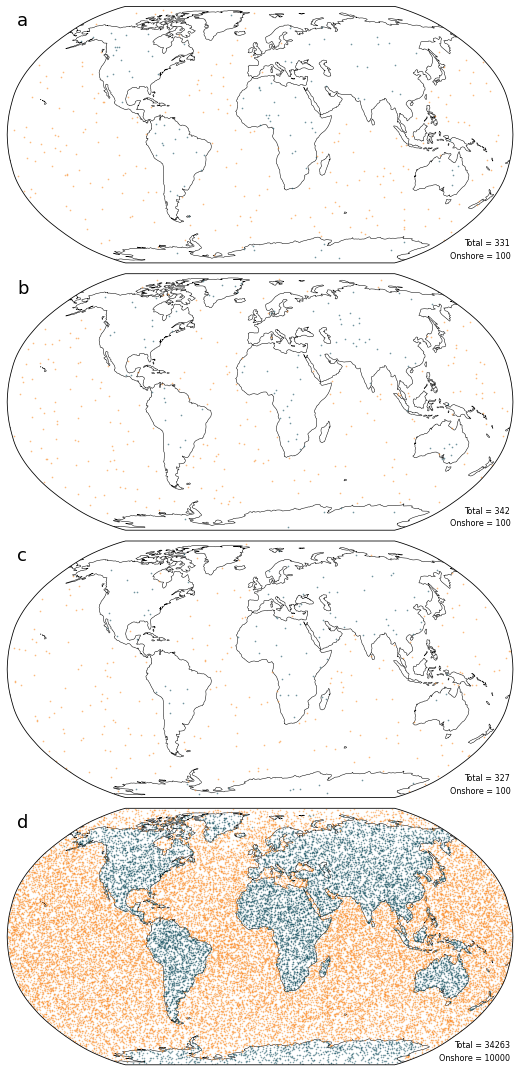

In [25]:
# Random points on global map

fig = plt.figure(figsize=(15, 15))
    
ax1 = fig.add_subplot(411, projection = ccrs.Robinson())
map_random_points(rset1, ax1, 0.5)
ax1.annotate("a", xy=(0.02, 0.98), xycoords='axes fraction', ha='left', va='top', fontsize = 18)

ax2 = fig.add_subplot(412, projection = ccrs.Robinson())
map_random_points(rset2, ax2, 0.5)
ax2.annotate("b", xy=(0.02, 0.98), xycoords='axes fraction', ha='left', va='top', fontsize = 18)

ax3 = fig.add_subplot(413, projection = ccrs.Robinson())
map_random_points(rset3, ax3, 0.5)
ax3.annotate("c", xy=(0.02, 0.98), xycoords='axes fraction', ha='left', va='top', fontsize = 18)

ax4 = fig.add_subplot(414, projection = ccrs.Robinson())
map_random_points(rset4, ax4, 0.3)
ax4.annotate("d", xy=(0.02, 0.98), xycoords='axes fraction', ha='left', va='top', fontsize = 18)

fig.tight_layout()

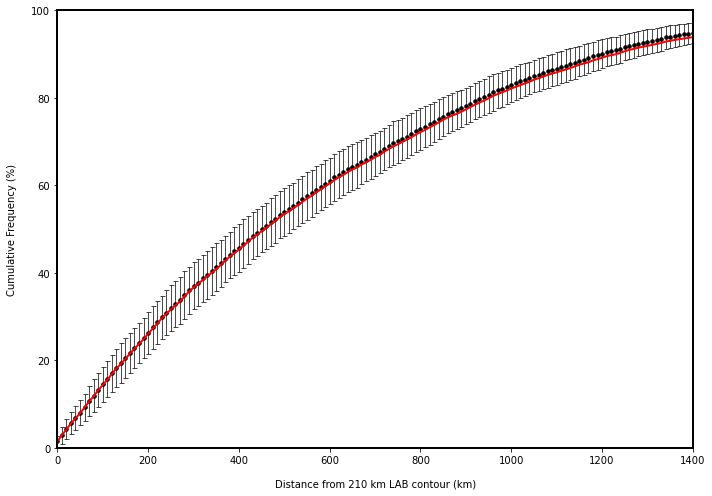

In [26]:
# Random points CDF

z = 210

matplotlib.rcParams['axes.linewidth'] = 2
fig = plt.figure(figsize = [10, 7])

ax1 = fig.add_subplot(111)
ax1.errorbar(cdf_rset4dist[2][0:141], 100 * np.array(cdf_rset4distsplit[0]),
            yerr = 100 * (np.array(cdf_rset4distsplit[1])),
            elinewidth = 0.7,
            capsize = 2.5,
            capthick = 0.7,
            color = 'k',
            linewidth = 0,
            marker = 'o',
            markersize = 3.5,
            zorder = 1)
ax1.plot(cdf_rset4dist[2][0:-1], 100 * cdf_rset4dist[0], color = 'r', linewidth = 2,
        zorder = 2)
ax1.set_xlabel("Distance from " + str(z) + " km LAB contour (km)", labelpad = 14)
ax1.set_ylabel("Cumulative Frequency (%)", labelpad = 14)
ax1.set_xlim([0, 1400])
ax1.set_ylim([0, 100])

fig.tight_layout()

## Topographic Maps

grdimage [WARNING]: The y-coordinates and range attribute are in conflict but range is exactly 180; we rely on this range


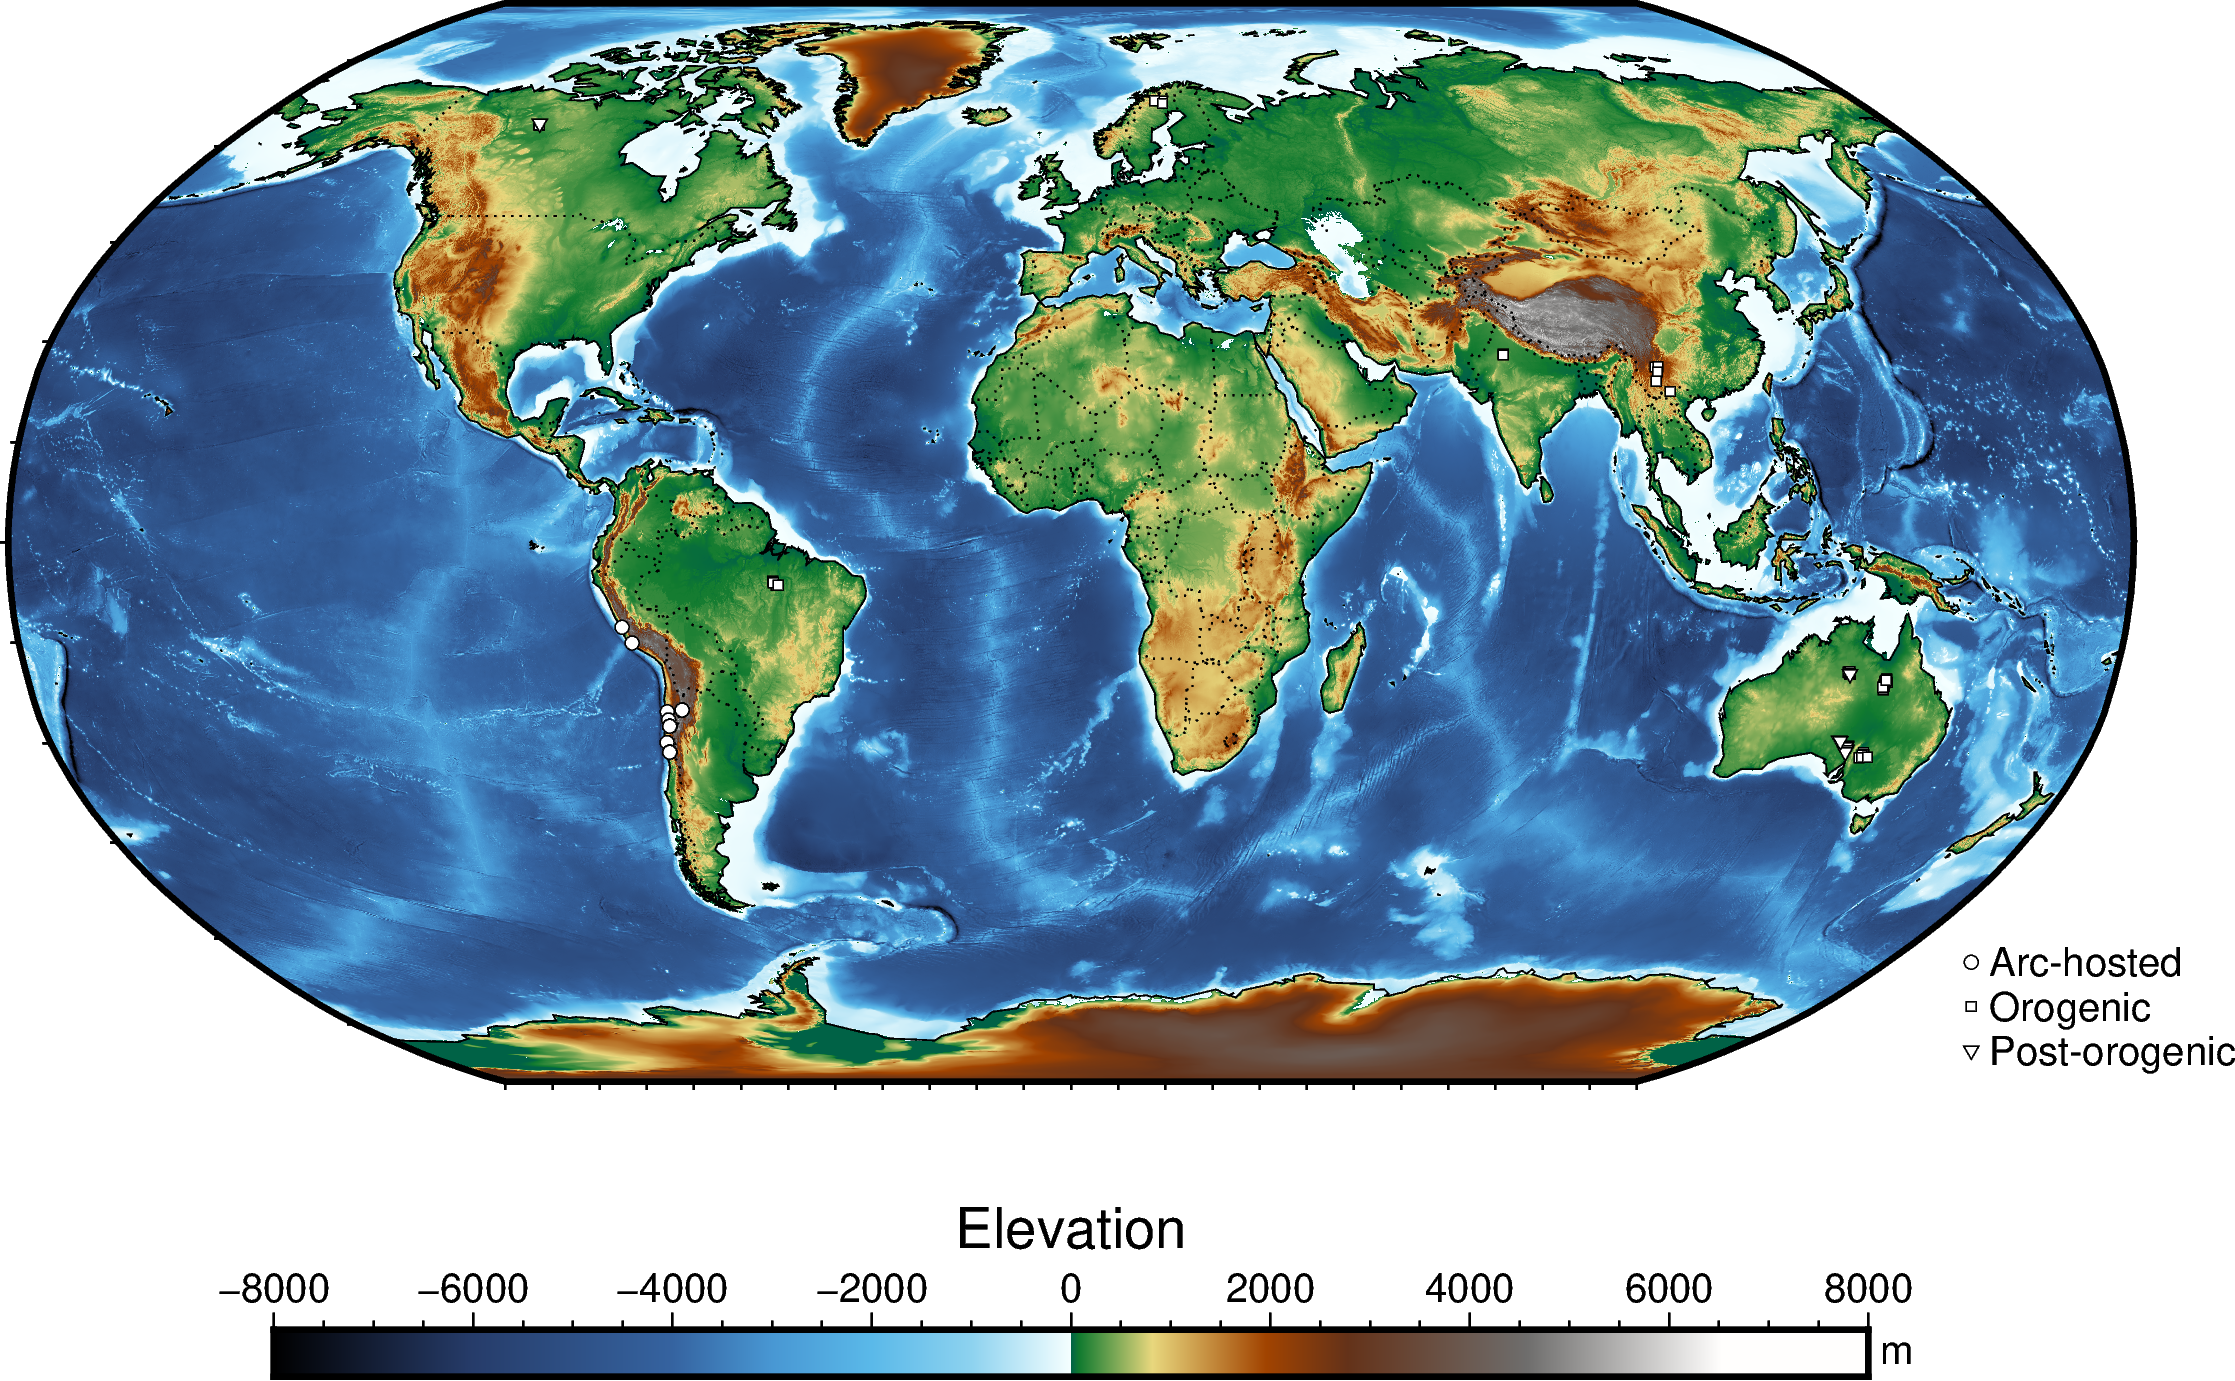

In [27]:
# Define deposit type:
#     Magmatic sulphide: "mags"
#     Five-element veins: "fevs"
#     IOCG: "iocg"


map_deposit_topo(deposit = "iocg")

## Global LAB Maps

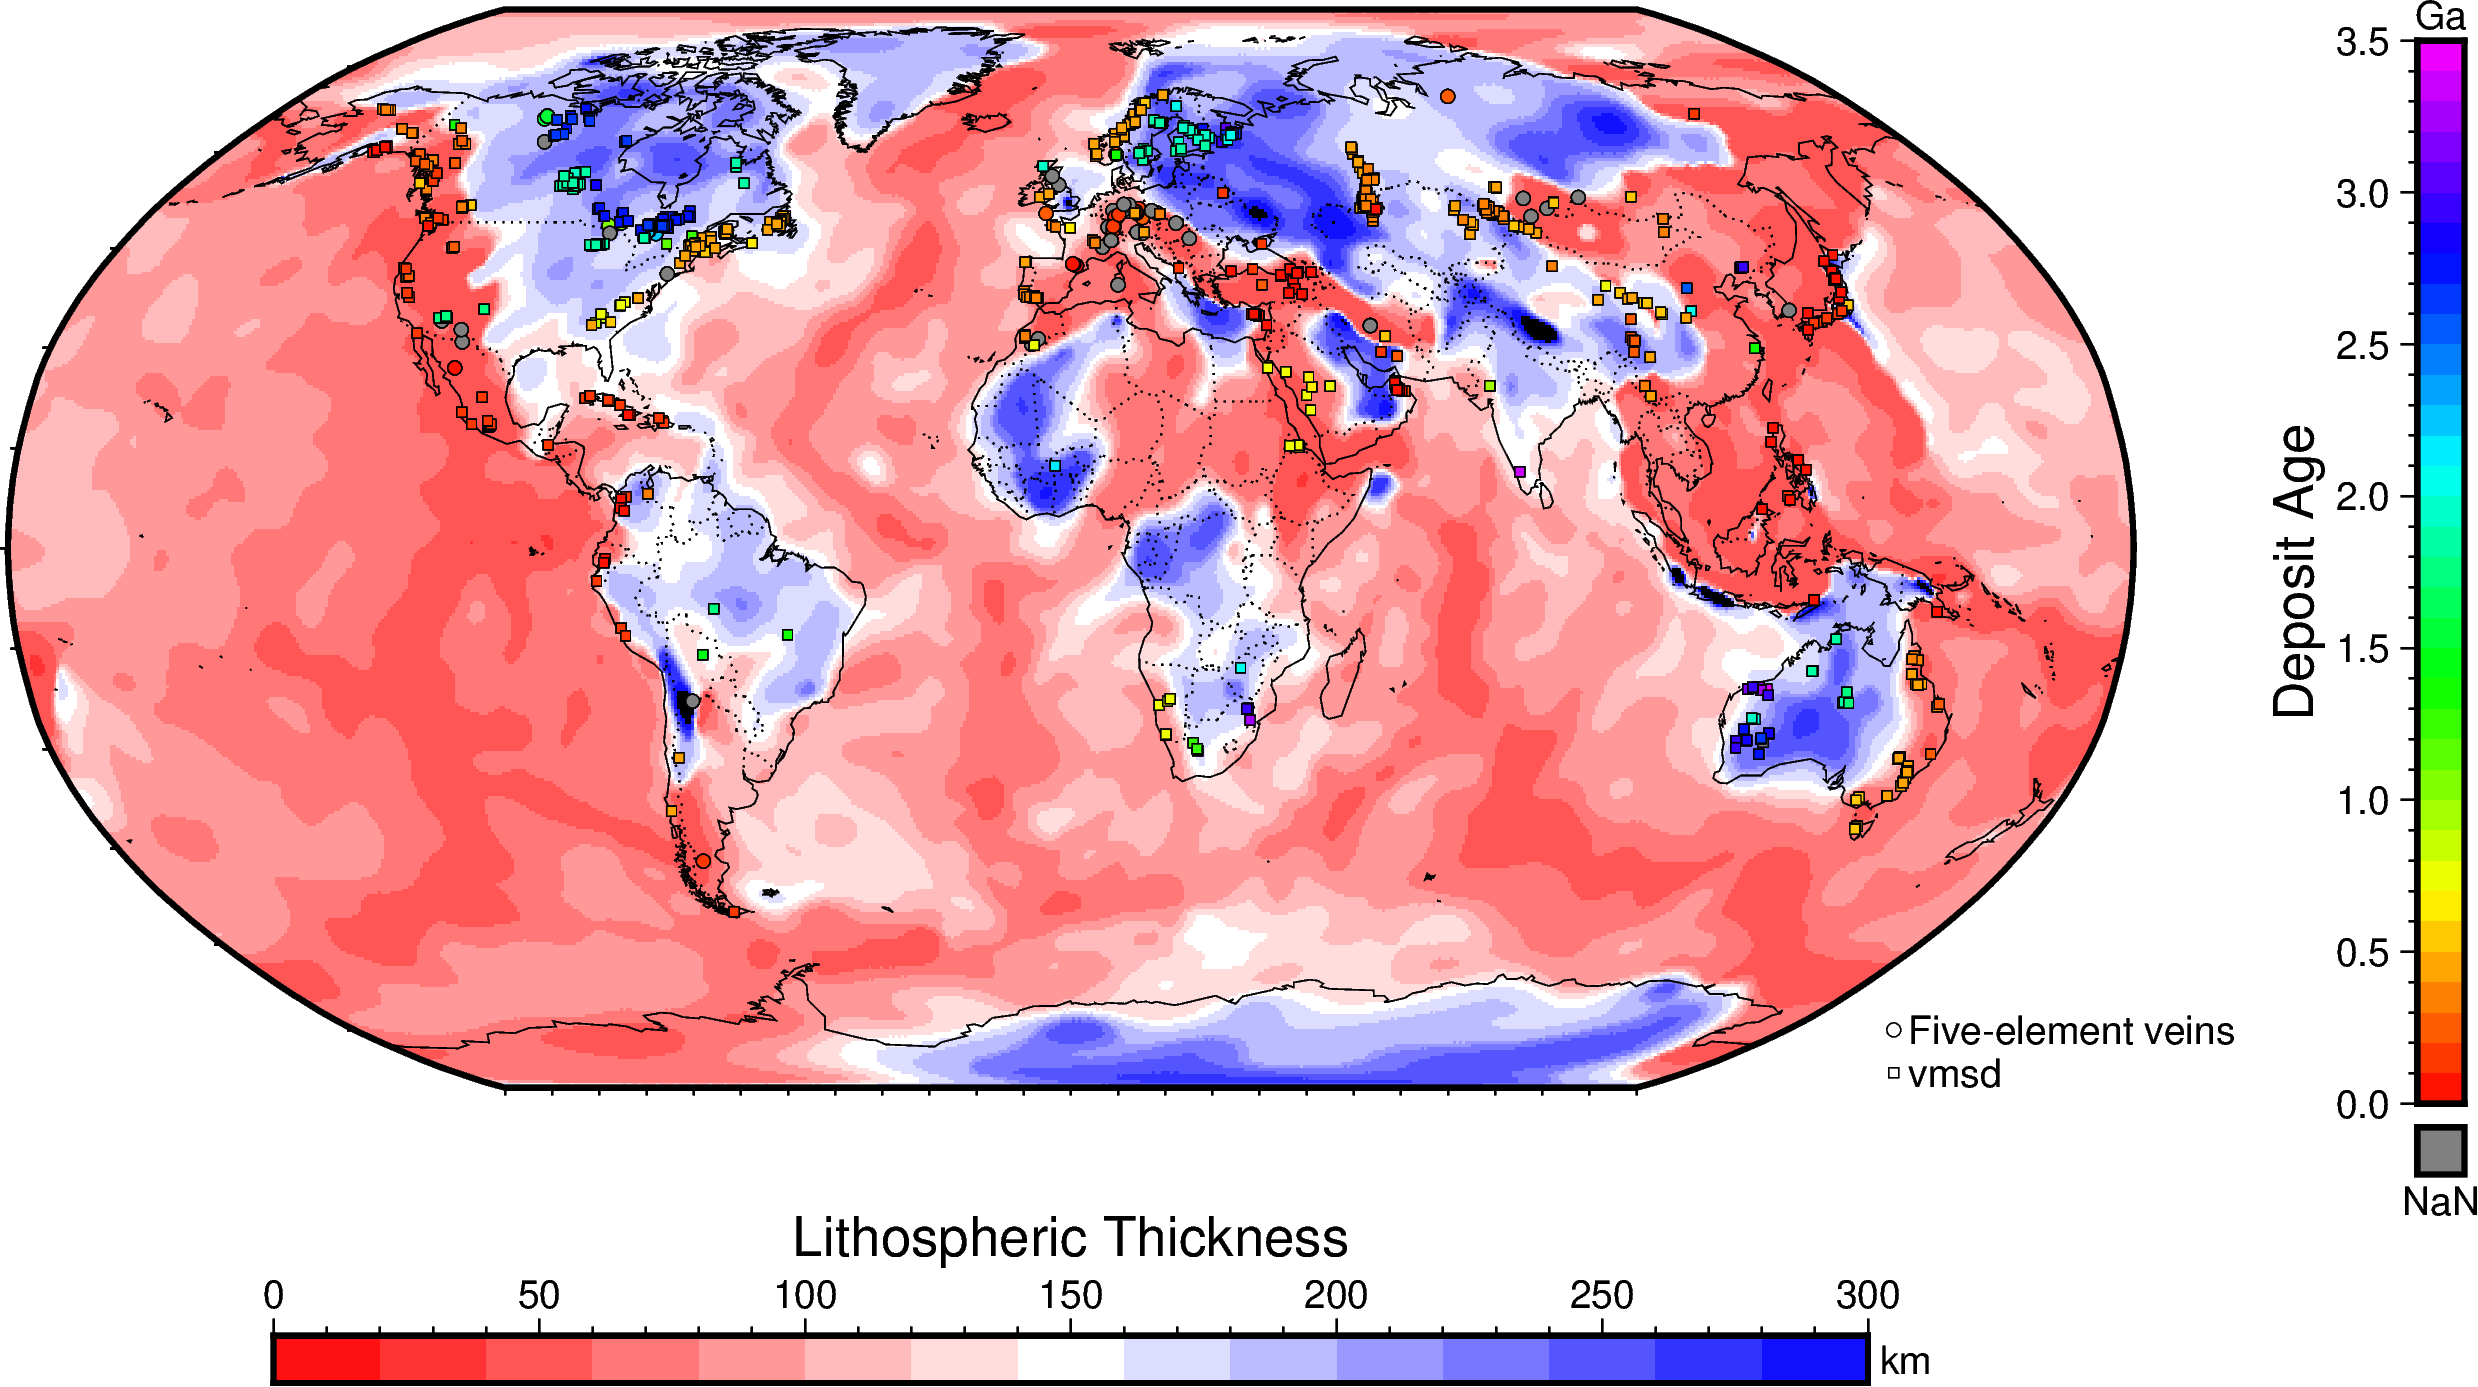

In [28]:
# Define deposit type:
#     Magmatic sulphide: "mags"
#     Five-element veins: "fevs"
#     IOCG: "iocg"
#     Arc-hosted IOCG: "arch"
#     Orogenic IOCG: "syno"
#     Post-orogenic IOCG: "poso"
#     VMS: "vmsd"

# Define LAB map:
#     "SLNAAFSA", "SL2013sv", "LITHO1.0", "A2006", "LithoRef18", "CAM2016"


map_globallab(["fevs", "vmsd"], "SLNAAFSA")

## Australian LAB Maps

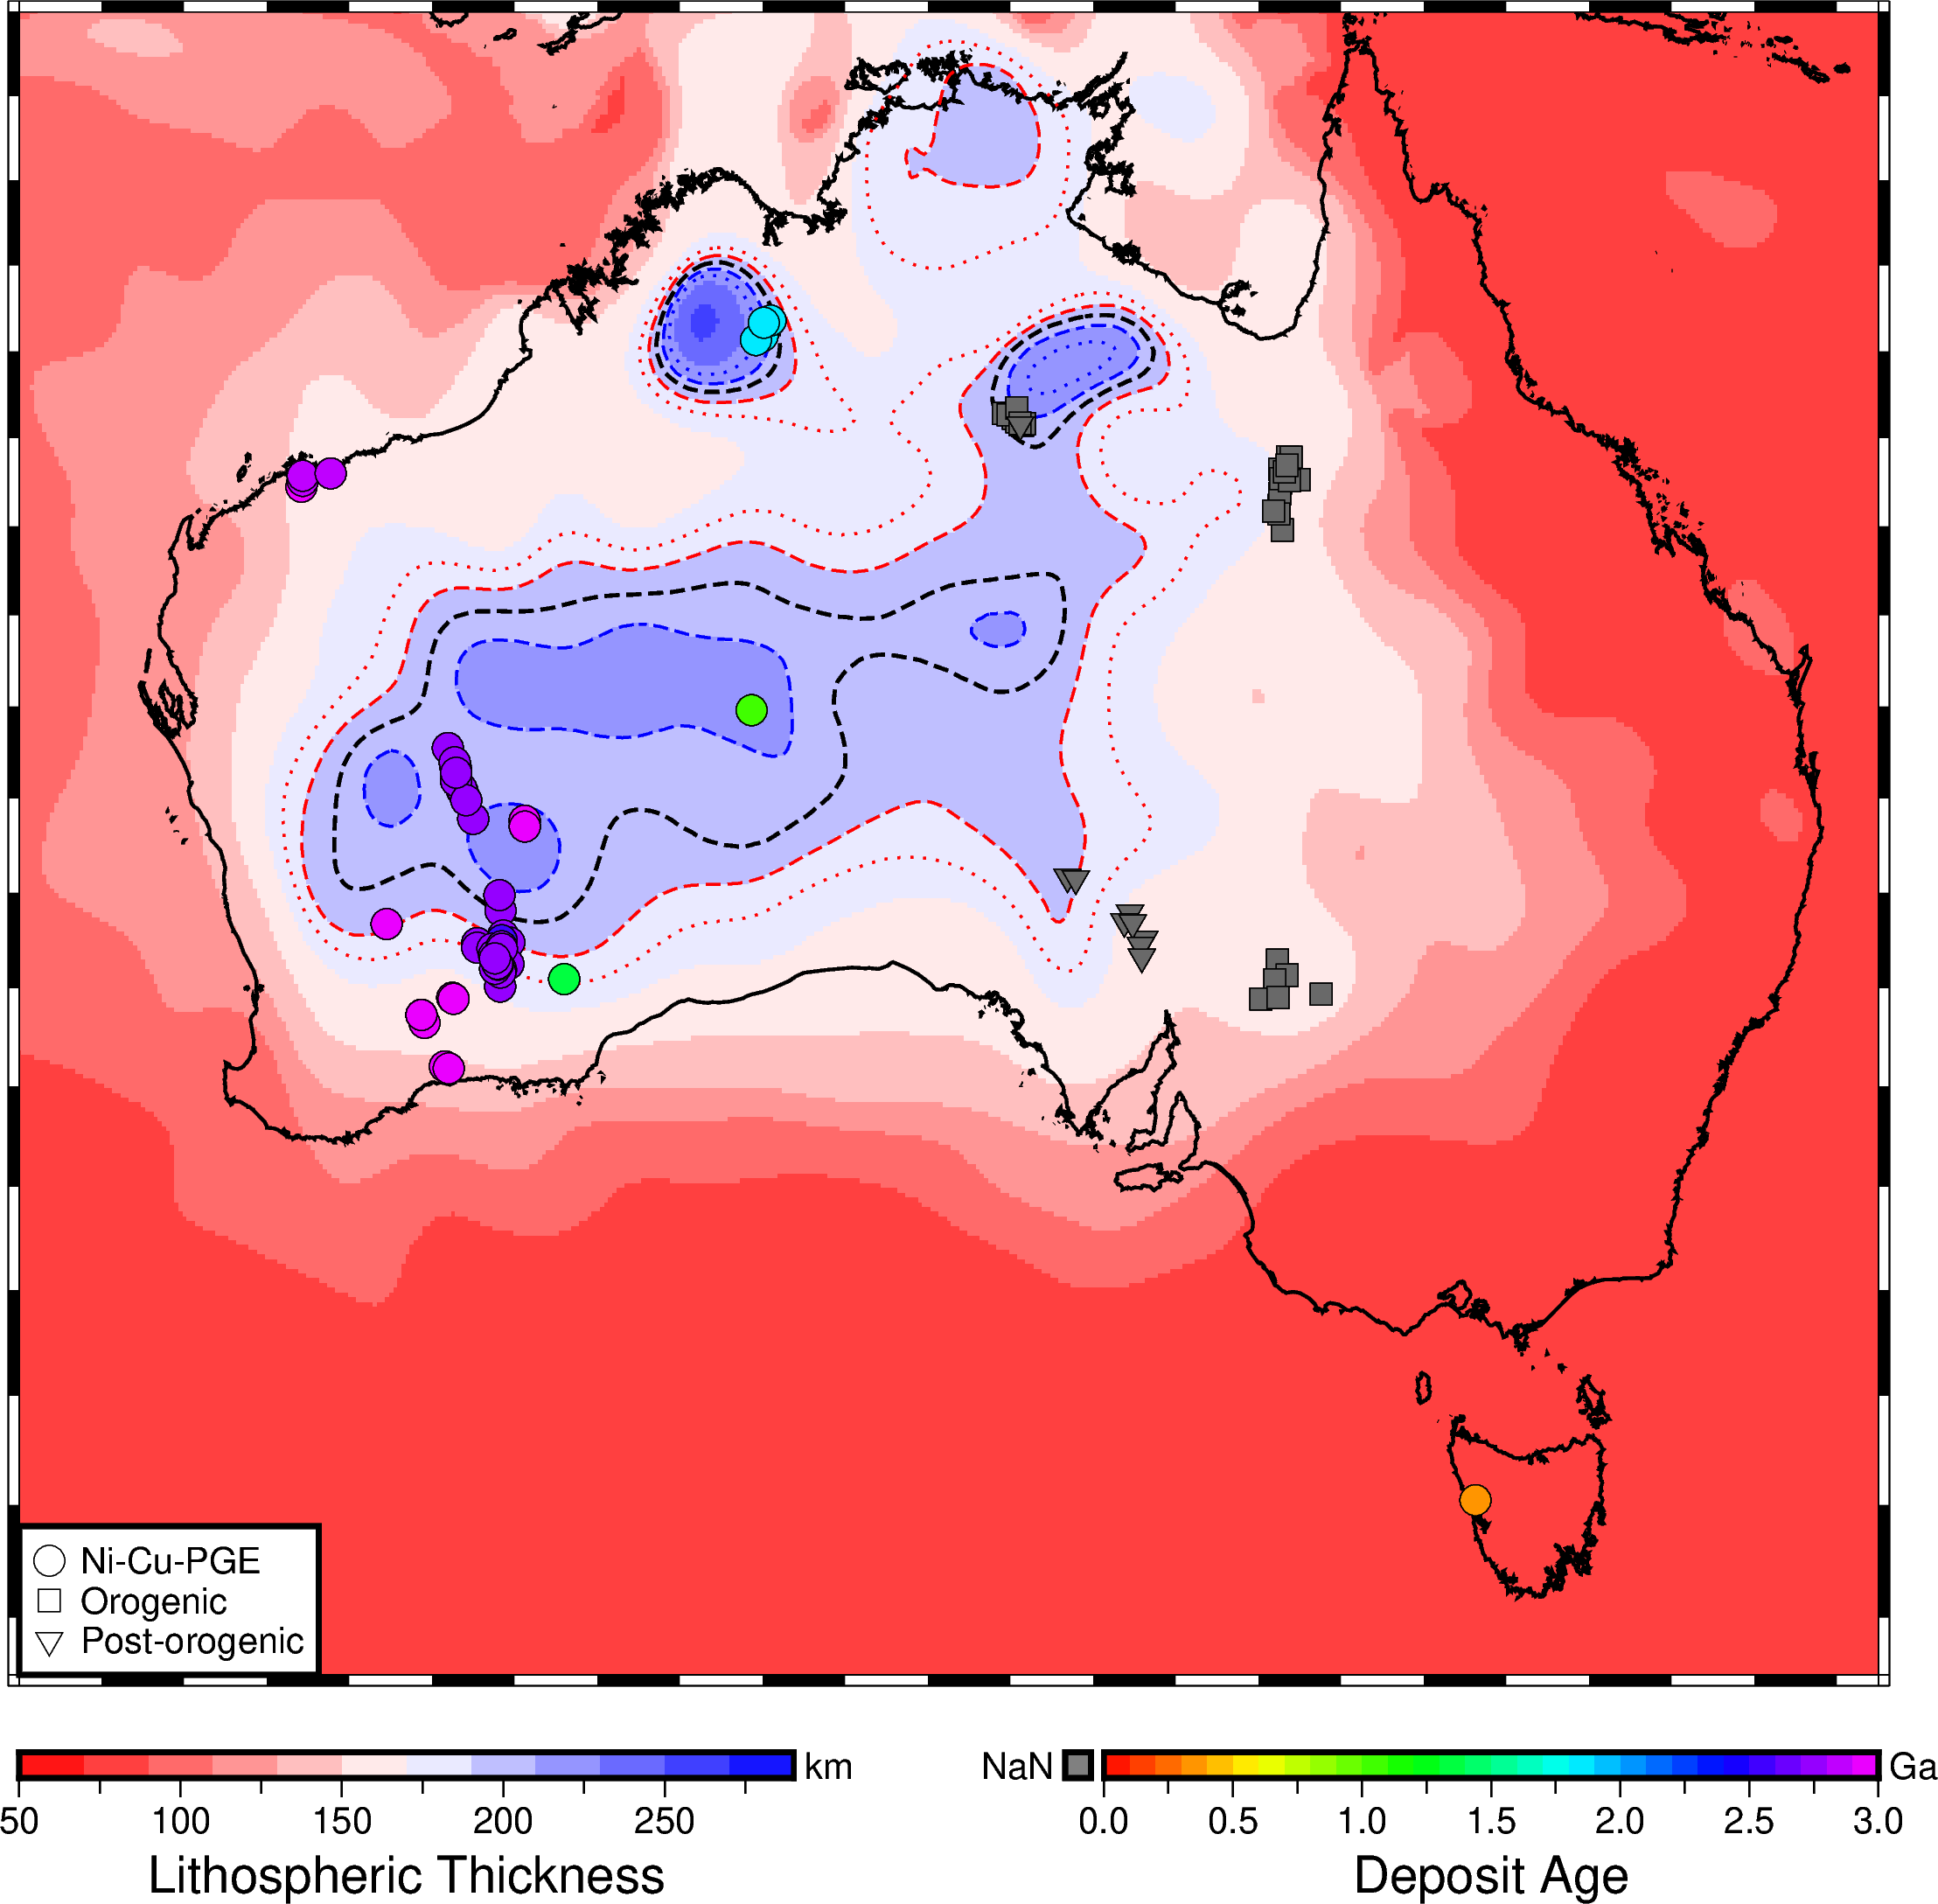

In [29]:
# Define deposit type:
#     Magmatic sulphide: "mags"
#     Five-element veins: "fevs"
#     IOCG: "iocg"
#     Arc-hosted IOCG: "arch"
#     Orogenic IOCG: "syno"
#     Post-orogenic IOCG: "poso"
#     VMS: "vmsd"

map_auslab(["mags", "syno", "poso"])

## CDF: Deposit vs Random Locations

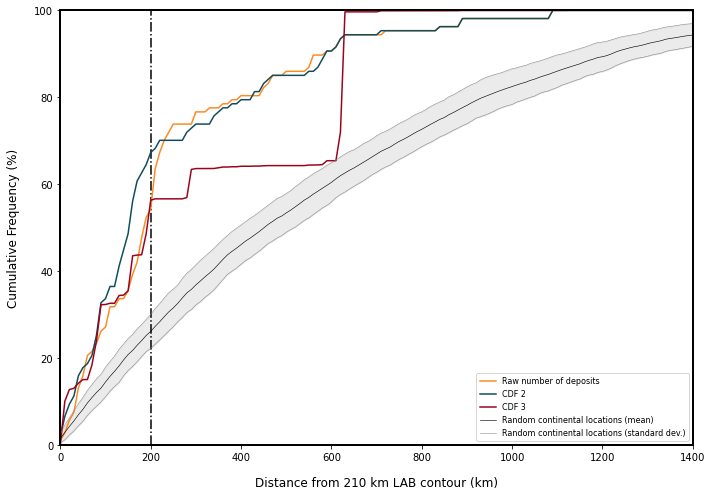

In [61]:
## Deposit/random index: [0] mags, [1] fevs, [2], iocg, [3] arch, [4] syno, [5] poso
## LAB map index: [0] SLNAAFSA, [1] SLNAAFSA + FR12, [2] SL2013sv, [3] LITHO1.0, [4] A2006, [5] LithoRef18, [6] CAM2016

deposit_index = 0
LAB_index = 0

# args = {'cdf1':all_depcdf[1][3], 'cdf2':None, 'cdf3': None,
#         'randomcdf_split':all_randomcdfsplit[1][3],'randomstd_split':all_randomstdsplit[1][3]}
args = {'cdf1':all_depcdf[deposit_index][LAB_index], 
        'randomcdf_split':all_randomcdfsplit[deposit_index][LAB_index],
        'randomstd_split':all_randomstdsplit[deposit_index][LAB_index],
        'cdf2':all_depcdf[0][1],
        'cdf3':cdf_magswt[1]}
plot_cdf(**args)  

## K-S Test Plots

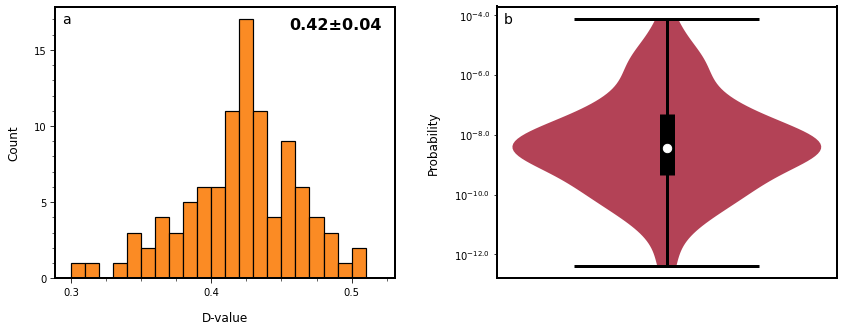

In [40]:
## Deposit/random index: [0] mags, [1] fevs, [2], iocg, [3] arch, [4] syno, [5] poso
## LAB map index: [0] SLNAAFSA, [1] SLNAAFSA + FR12, [2] SL2013sv, [3] LITHO1.0, [4] A2006, [5] LithoRef18, [6] CAM2016

# plot_ks(all_d[0][0], all_p[0][0])
plot_ks(d_regglo[0][0], p_regglo[0][0])


## CDF and K-S Test Plots: Deposit vs Deposit Locations

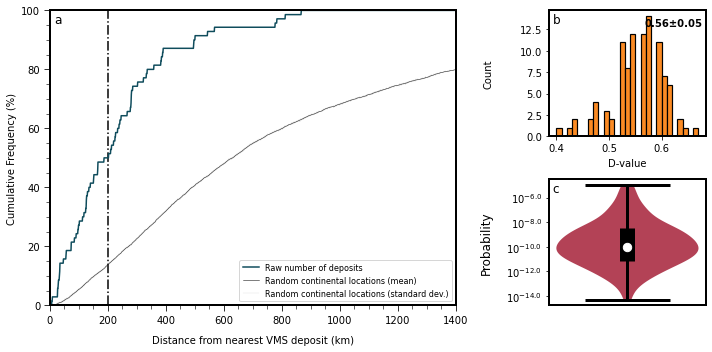

In [44]:
## Deposit/random index: [0] mags, [1] fevs, [2], iocg, [3] arch, [4] syno, [5] poso
## LAB map index: [0] SLNAAFSA, [1] SLNAAFSA + FR12, [2] SL2013sv, [3] LITHO1.0, [4] A2006, [5] LithoRef18, [6] CAM2016

plot_dvd(cdf_fevsvmsd, cdf_rfevsvmsd, std_rfevsvmsd, dfevsvmsd[0], pfevsvmsd[0])

## p-values across a range of LAB depths

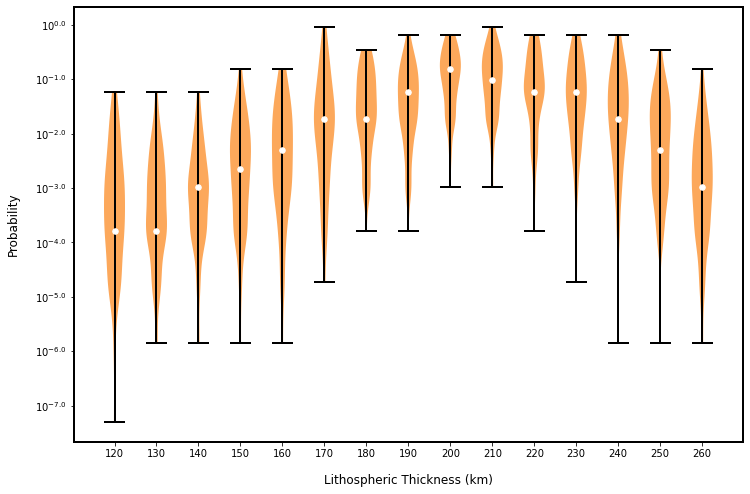

In [38]:
# Define deposit type:
#     Magmatic sulphide: "mags"
#     Five-element veins: "fevs"
#     IOCG: "iocg"
#     Arc-hosted IOCG: "arch"
#     Orogenic IOCG: "syno"
#     Post-orogenic IOCG: "poso"

plot_psweep("arch")